In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [70]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

### Task 1

In [71]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [73]:
print("Shape of data (samples, features): ",df.shape)

Shape of data (samples, features):  (1460, 81)


In [74]:
df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [132]:
df_numeric = df.select_dtypes(include='number')
df_categorical = df.select_dtypes(include='object')

In [76]:
print(df_numeric.columns)
print(len(df_numeric.columns))

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
38


In [77]:
print(df_categorical.columns)
print(len(df_categorical.columns))

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
43


In [78]:
nan_per_num = df_numeric.isna().sum()/len(df_numeric)*100
print(nan_per_num)

Id                0.000000
MSSubClass        0.000000
LotFrontage      17.739726
LotArea           0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
MasVnrArea        0.547945
BsmtFinSF1        0.000000
BsmtFinSF2        0.000000
BsmtUnfSF         0.000000
TotalBsmtSF       0.000000
1stFlrSF          0.000000
2ndFlrSF          0.000000
LowQualFinSF      0.000000
GrLivArea         0.000000
BsmtFullBath      0.000000
BsmtHalfBath      0.000000
FullBath          0.000000
HalfBath          0.000000
BedroomAbvGr      0.000000
KitchenAbvGr      0.000000
TotRmsAbvGrd      0.000000
Fireplaces        0.000000
GarageYrBlt       5.547945
GarageCars        0.000000
GarageArea        0.000000
WoodDeckSF        0.000000
OpenPorchSF       0.000000
EnclosedPorch     0.000000
3SsnPorch         0.000000
ScreenPorch       0.000000
PoolArea          0.000000
MiscVal           0.000000
MoSold            0.000000
YrSold            0.000000
S

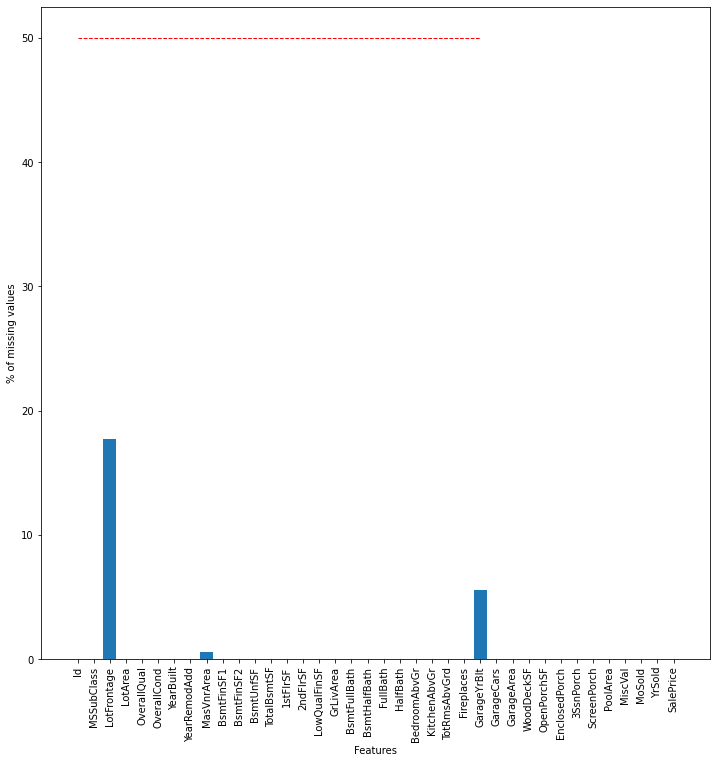

In [79]:
plt.plot([0, 25], [50,50], 'r--', lw=1)
plt.bar(range(len(nan_per_num)),nan_per_num)
plt.xlabel('Features')
plt.ylabel('% of missing values')
plt.xticks(list(range(len(df_numeric.columns))),list(df_numeric.columns.values),rotation='vertical')
plt.show()

In [80]:
df_numeric_non_null = df_numeric.dropna(axis=0)
df_numeric_non_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1121 non-null   int64  
 1   MSSubClass     1121 non-null   int64  
 2   LotFrontage    1121 non-null   float64
 3   LotArea        1121 non-null   int64  
 4   OverallQual    1121 non-null   int64  
 5   OverallCond    1121 non-null   int64  
 6   YearBuilt      1121 non-null   int64  
 7   YearRemodAdd   1121 non-null   int64  
 8   MasVnrArea     1121 non-null   float64
 9   BsmtFinSF1     1121 non-null   int64  
 10  BsmtFinSF2     1121 non-null   int64  
 11  BsmtUnfSF      1121 non-null   int64  
 12  TotalBsmtSF    1121 non-null   int64  
 13  1stFlrSF       1121 non-null   int64  
 14  2ndFlrSF       1121 non-null   int64  
 15  LowQualFinSF   1121 non-null   int64  
 16  GrLivArea      1121 non-null   int64  
 17  BsmtFullBath   1121 non-null   int64  
 18  BsmtHalf

In [187]:
# Model 0 - Baseline Model
from sklearn.linear_model import LinearRegression
X_num = df_numeric_non_null.drop(['SalePrice'], axis=1)
y_num = df_numeric_non_null[['SalePrice']]
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_num, y_num, test_size=0.20, random_state=453)
regression_model = LinearRegression()
regression_model.fit(X_num_train, y_num_train)

LinearRegression()

In [188]:
print("The score for the model is",regression_model.score(X_num_test,y_num_test))

The score for the model is 0.8614306793128528


### Task 2

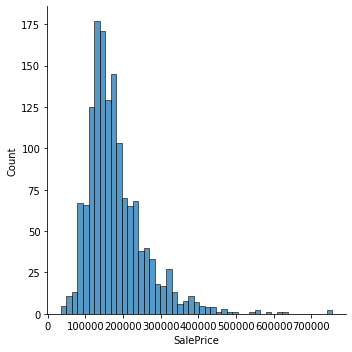

In [93]:
sns.displot(df['SalePrice'])

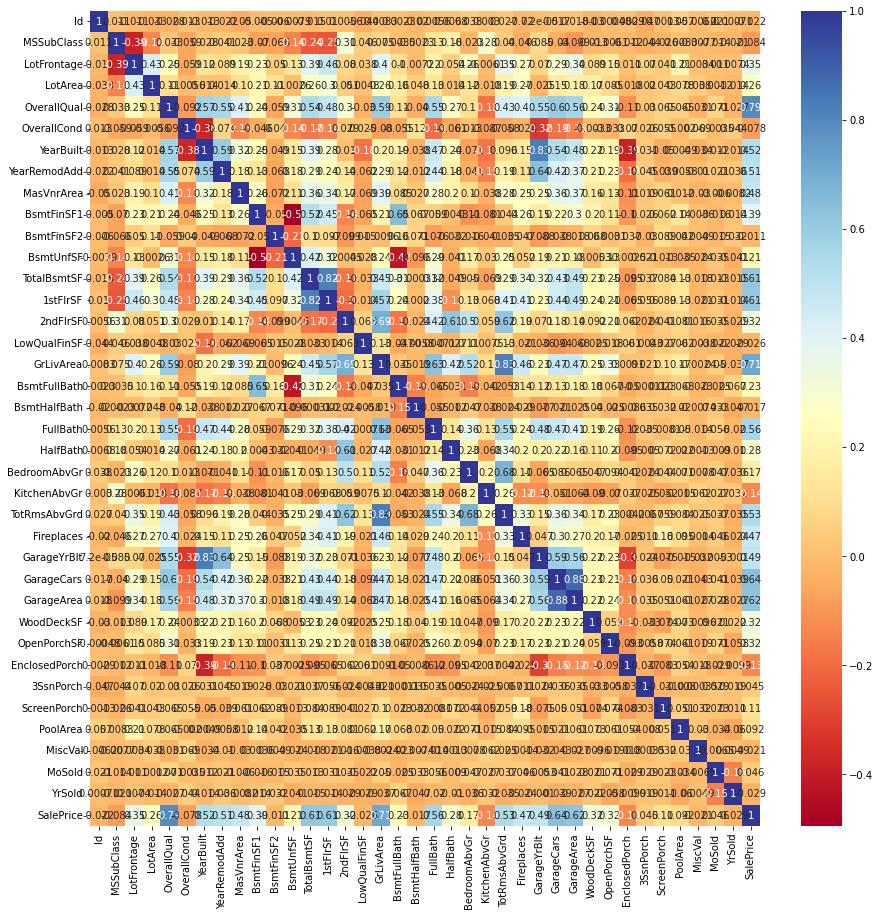

In [94]:
plt.figure(figsize=(15,15))
sns.heatmap(df_numeric.corr(), annot = True, cmap = 'RdYlBu');

In [108]:
df_numeric_corr = df_numeric.corr()
df_numeric_corr = df_numeric_corr.apply(lambda x: abs(x))
df_numeric_corr = df_numeric_corr['SalePrice'].sort_values(ascending=False)

In [109]:
print(df_numeric_corr)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePr

Removing those numeric columns that have less than 10% correlation

In [110]:
cols_num_dropped = df_numeric_corr[df_numeric_corr.values<0.1].index
print(list(cols_num_dropped))
print('No. of columns dropped:',len(cols_num_dropped))

['PoolArea', 'MSSubClass', 'OverallCond', 'MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']
No. of columns dropped: 11


In [111]:
df_numeric_cleaned = df_numeric.drop(list(cols_num_dropped), axis=1)

In [112]:
df_numeric_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1201 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   OverallQual    1460 non-null   int64  
 3   YearBuilt      1460 non-null   int64  
 4   YearRemodAdd   1460 non-null   int64  
 5   MasVnrArea     1452 non-null   float64
 6   BsmtFinSF1     1460 non-null   int64  
 7   BsmtUnfSF      1460 non-null   int64  
 8   TotalBsmtSF    1460 non-null   int64  
 9   1stFlrSF       1460 non-null   int64  
 10  2ndFlrSF       1460 non-null   int64  
 11  GrLivArea      1460 non-null   int64  
 12  BsmtFullBath   1460 non-null   int64  
 13  FullBath       1460 non-null   int64  
 14  HalfBath       1460 non-null   int64  
 15  BedroomAbvGr   1460 non-null   int64  
 16  KitchenAbvGr   1460 non-null   int64  
 17  TotRmsAbvGrd   1460 non-null   int64  
 18  Fireplac

In [113]:
for col in df_numeric_cleaned.columns.values: # Iterate through all numeric columns
    if (pd.isna(df_numeric_cleaned[col]).sum())>0: # If column has null values
        df_numeric_cleaned[col] = df_numeric_cleaned[col].fillna(df_numeric_cleaned[col].median())

In [114]:
df_numeric_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1460 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   OverallQual    1460 non-null   int64  
 3   YearBuilt      1460 non-null   int64  
 4   YearRemodAdd   1460 non-null   int64  
 5   MasVnrArea     1460 non-null   float64
 6   BsmtFinSF1     1460 non-null   int64  
 7   BsmtUnfSF      1460 non-null   int64  
 8   TotalBsmtSF    1460 non-null   int64  
 9   1stFlrSF       1460 non-null   int64  
 10  2ndFlrSF       1460 non-null   int64  
 11  GrLivArea      1460 non-null   int64  
 12  BsmtFullBath   1460 non-null   int64  
 13  FullBath       1460 non-null   int64  
 14  HalfBath       1460 non-null   int64  
 15  BedroomAbvGr   1460 non-null   int64  
 16  KitchenAbvGr   1460 non-null   int64  
 17  TotRmsAbvGrd   1460 non-null   int64  
 18  Fireplac

In [115]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1452 non-null   object
 18  ExterQual      1460 non-null

In [116]:
nan_per_cat = df_categorical.isna().sum()/len(df_categorical)*100
print(nan_per_cat)

MSZoning          0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
BsmtCond          2.534247
BsmtExposure      2.602740
BsmtFinType1      2.534247
BsmtFinType2      2.602740
Heating           0.000000
HeatingQC         0.000000
CentralAir        0.000000
Electrical        0.068493
KitchenQual       0.000000
Functional        0.000000
FireplaceQu      47.260274
GarageType        5.547945
GarageFinish      5.547945
GarageQual        5.547945
GarageCond        5.547945
P

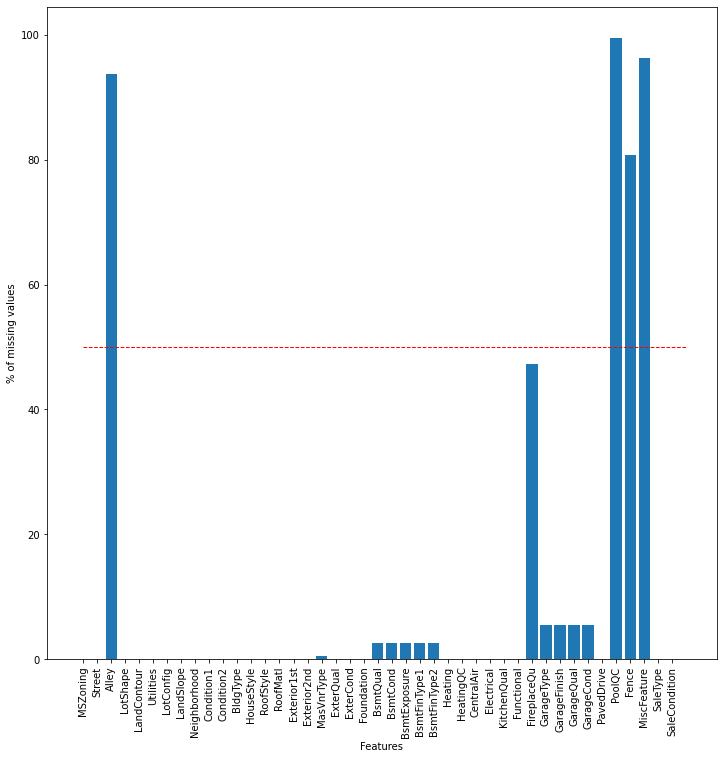

In [133]:
plt.plot([0, 43], [50,50], 'r--', lw=1)
plt.bar(range(len(nan_per_cat)),nan_per_cat)
plt.xlabel('Features')
plt.ylabel('% of missing values')
plt.xticks(list(range(len(df_categorical.columns))),list(df_categorical.columns.values),rotation='vertical')
plt.show()

Removing those numeric columns that have more than 50% missing values, filling remaining null values with Mode

In [134]:
df_categorical_cleaned = df_categorical.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1)

In [135]:
df_categorical_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  MasVnrType     1452 non-null   object
 17  ExterQual      1460 non-null   object
 18  ExterCond      1460 non-null

In [148]:
for col in df_categorical_cleaned.columns: # Iterate through all categorical columns
    if (pd.isna(df_categorical_cleaned[col]).sum())>0: # If column has null values
            df_categorical_cleaned[col].fillna(df_categorical_cleaned[col].value_counts().index[0], inplace=True) # Else, fill the null values with the mode of the non-null values

In [149]:
df_categorical_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  MasVnrType     1460 non-null   object
 17  ExterQual      1460 non-null   object
 18  ExterCond      1460 non-null

In [150]:
for col in df_categorical.columns:
    df_categorical[col] = df_categorical[col].astype('category').cat.codes # Encoding categorical columns
    
merged_df = pd.concat([df_numeric_cleaned,df_categorical],axis=1) # Merging the two dataframes

In [155]:
(merged_df.isna().sum()/len(merged_df)*100).unique()

array([0.])

In [157]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1460 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   OverallQual    1460 non-null   int64  
 3   YearBuilt      1460 non-null   int64  
 4   YearRemodAdd   1460 non-null   int64  
 5   MasVnrArea     1460 non-null   float64
 6   BsmtFinSF1     1460 non-null   int64  
 7   BsmtUnfSF      1460 non-null   int64  
 8   TotalBsmtSF    1460 non-null   int64  
 9   1stFlrSF       1460 non-null   int64  
 10  2ndFlrSF       1460 non-null   int64  
 11  GrLivArea      1460 non-null   int64  
 12  BsmtFullBath   1460 non-null   int64  
 13  FullBath       1460 non-null   int64  
 14  HalfBath       1460 non-null   int64  
 15  BedroomAbvGr   1460 non-null   int64  
 16  KitchenAbvGr   1460 non-null   int64  
 17  TotRmsAbvGrd   1460 non-null   int64  
 18  Fireplac

In [156]:
merged_df.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,65.0,8450,7,2003,2003,196.0,706,150,856,856,...,1,1,4,4,2,-1,-1,-1,8,4
1,80.0,9600,6,1976,1976,0.0,978,284,1262,1262,...,1,1,4,4,2,-1,-1,-1,8,4
2,68.0,11250,7,2001,2002,162.0,486,434,920,920,...,1,1,4,4,2,-1,-1,-1,8,4
3,60.0,9550,7,1915,1970,0.0,216,540,756,961,...,5,2,4,4,2,-1,-1,-1,8,0
4,84.0,14260,8,2000,2000,350.0,655,490,1145,1145,...,1,1,4,4,2,-1,-1,-1,8,4


In [185]:
# Model 1 - After Preprocessing Model
from sklearn.linear_model import LinearRegression
X_merge = merged_df.drop(['SalePrice'], axis=1)
y_merge = merged_df[['SalePrice']]
X_merge_train, X_merge_test, y_merge_train, y_merge_test = train_test_split(X_merge, y_merge, test_size=0.20, random_state=453)
regression_model_merge = LinearRegression()
regression_model_merge.fit(X_merge_train, y_merge_train)

LinearRegression()

In [186]:
print("The score for the model is",regression_model_merge.score(X_merge_test,y_merge_test))

The score for the model is 0.9123930085546794


In [189]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [195]:
cols_needed = list(merged_df.columns)
cols_needed.remove('SalePrice')

In [196]:
df_test = df_test[cols_needed]

In [197]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1232 non-null   float64
 1   LotArea        1459 non-null   int64  
 2   OverallQual    1459 non-null   int64  
 3   YearBuilt      1459 non-null   int64  
 4   YearRemodAdd   1459 non-null   int64  
 5   MasVnrArea     1444 non-null   float64
 6   BsmtFinSF1     1458 non-null   float64
 7   BsmtUnfSF      1458 non-null   float64
 8   TotalBsmtSF    1458 non-null   float64
 9   1stFlrSF       1459 non-null   int64  
 10  2ndFlrSF       1459 non-null   int64  
 11  GrLivArea      1459 non-null   int64  
 12  BsmtFullBath   1457 non-null   float64
 13  FullBath       1459 non-null   int64  
 14  HalfBath       1459 non-null   int64  
 15  BedroomAbvGr   1459 non-null   int64  
 16  KitchenAbvGr   1459 non-null   int64  
 17  TotRmsAbvGrd   1459 non-null   int64  
 18  Fireplac

In [198]:
df_test_numeric = df_test.select_dtypes(include='number')
df_test_categorical = df_test.select_dtypes(include='object')

In [199]:
for col in df_test_numeric.columns.values: # Iterate through all numeric columns
    if (pd.isna(df_test_numeric[col]).sum())>0: # If column has null values
        df_test_numeric[col] = df_test_numeric[col].fillna(df_test_numeric[col].median())

In [200]:
for col in df_test_categorical.columns: # Iterate through all categorical columns
    if (pd.isna(df_test_categorical[col]).sum())>0: # If column has null values
            df_test_categorical[col].fillna(df_test_categorical[col].value_counts().index[0], inplace=True) # Else, fill the null values with the mode of the non-null values

In [201]:
for col in df_test_categorical.columns:
    df_test_categorical[col] = df_test_categorical[col].astype('category').cat.codes # Encoding categorical columns
    
merged_df = pd.concat([df_test_numeric,df_test_categorical],axis=1) # Merging the two dataframes

In [203]:
preds = regression_model_merge.predict(merged_df)

In [204]:
dfid = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_sub = dfid[['Id']]
df_sub['SalePrice'] = preds
df_sub.head()

,Id,SalePrice
0,1461,64412.054194
1,1462,121084.115071
2,1463,136744.071618
3,1464,153884.011283
4,1465,153137.622631


In [205]:
df_sub.to_csv('submission1.csv',index=False)